In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
df = pd.read_csv("/content/household_power_consumption.txt", sep=';')

# Replace ? with NaN
df.replace("?", np.nan, inplace=True)

# Convert to numeric
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col])

# Combine Date + Time
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('DateTime')

df.head()


/tmp/ipython-input-2063502410.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/household_power_consumption.txt", sep=';')
/tmp/ipython-input-2063502410.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


TASK 1 - EDA

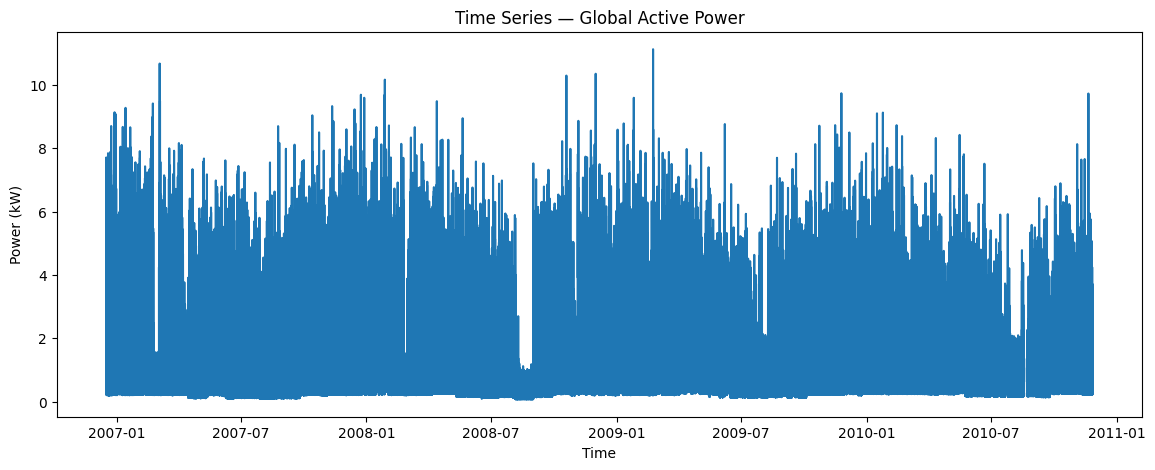

In [3]:
plt.figure(figsize=(14,5))
plt.plot(df['DateTime'], df['Global_active_power'])
plt.title("Time Series — Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.show()


In [4]:
print("Missing values:\n", df.isna().sum())

# Identify abnormal values (0 or extremely high)
abnormal = df[(df['Global_active_power'] <= 0) | (df['Global_active_power'] > 7)]
abnormal.head()


Missing values:
 Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
DateTime                     0
dtype: int64


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
21,16/12/2006,17:45:00,7.706,0.000,230.98,33.2,0.0,0.0,17.0,2006-12-16 17:45:00
22,16/12/2006,17:46:00,7.026,0.000,232.21,30.6,0.0,0.0,16.0,2006-12-16 17:46:00
939,17/12/2006,09:03:00,7.064,0.124,235.57,30.0,0.0,37.0,0.0,2006-12-17 09:03:00
3803,19/12/2006,08:47:00,7.828,0.182,232.20,33.6,36.0,72.0,17.0,2006-12-19 08:47:00
3804,19/12/2006,08:48:00,7.840,0.188,232.55,33.6,36.0,71.0,16.0,2006-12-19 08:48:00


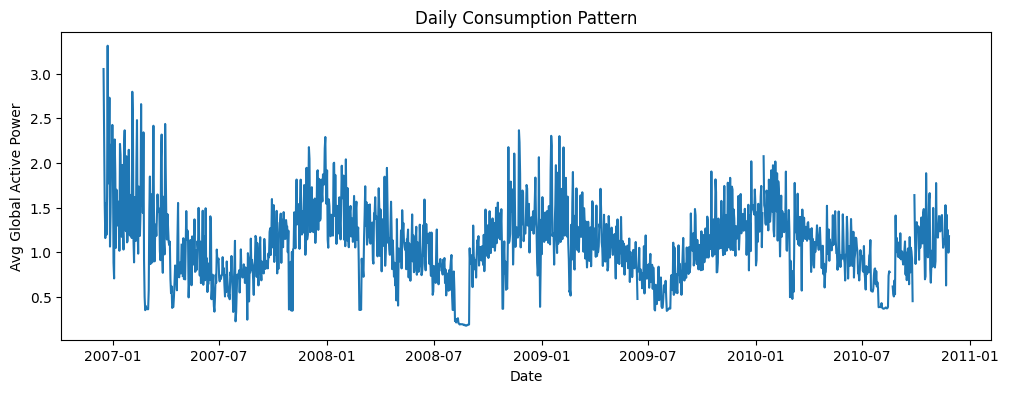

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
daily = df.groupby(df['Date'])['Global_active_power'].mean()

plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values)
plt.title("Daily Consumption Pattern")
plt.xlabel("Date")
plt.ylabel("Avg Global Active Power")
plt.show()


TASK 2 - SUPERVISED LEARNING

In [6]:
df_forecast = df[['DateTime','Global_active_power']].copy()
df_forecast.set_index('DateTime', inplace=True)

# Create lag features (previous 1,2,3 hours)
df_forecast['lag1'] = df_forecast['Global_active_power'].shift(1)
df_forecast['lag2'] = df_forecast['Global_active_power'].shift(2)
df_forecast['lag3'] = df_forecast['Global_active_power'].shift(3)

df_forecast.dropna(inplace=True)

X = df_forecast[['lag1','lag2','lag3']]
y = df_forecast['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

pred = model.predict(X_test)


In [9]:
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.07902562145447505
RMSE: 0.21644395683133952


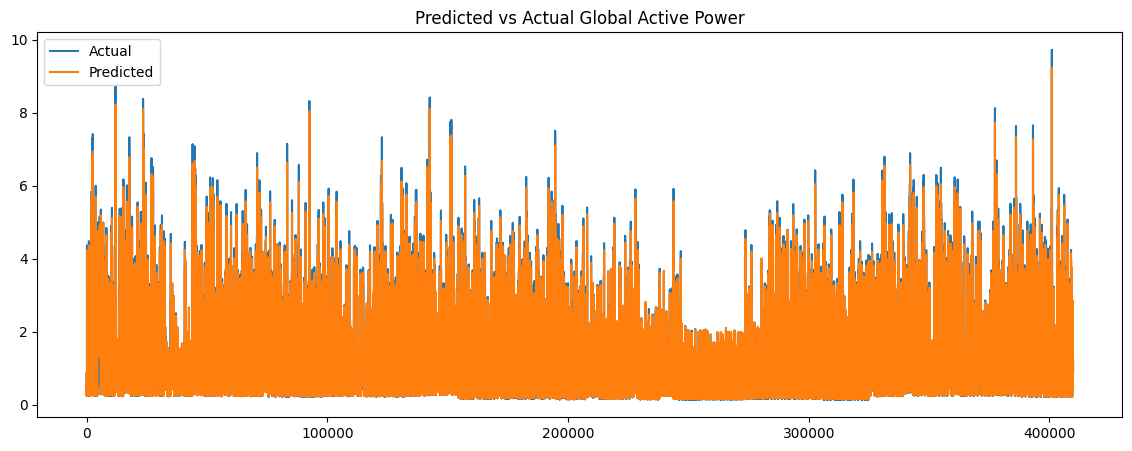

In [10]:
plt.figure(figsize=(14,5))
plt.plot(y_test.values, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.title("Predicted vs Actual Global Active Power")
plt.show()


TASK 3 - UNSUPERVISED LEARNING

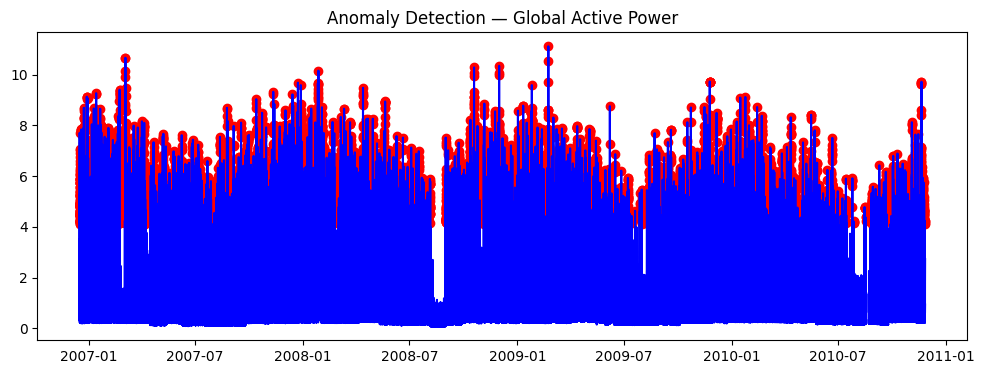

In [11]:
iso = IsolationForest(contamination=0.02)
df['anomaly'] = iso.fit_predict(df[['Global_active_power']])

anomalies = df[df['anomaly'] == -1]

plt.figure(figsize=(12,4))
plt.plot(df['DateTime'], df['Global_active_power'], color='blue')
plt.scatter(anomalies['DateTime'], anomalies['Global_active_power'], color='red')
plt.title("Anomaly Detection — Global Active Power")
plt.show()


In [13]:
daily_profile = df.groupby(df['Date'])['Global_active_power'].mean().to_frame()
daily_profile.dropna(inplace=True) # Drop rows with NaN values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_profile)

kmeans = KMeans(n_clusters=3, random_state=42)
daily_profile['Cluster'] = kmeans.fit_predict(scaled)
daily_profile.head()

,Global_active_power,Cluster
Date,,
2006-12-16,3.053475,2
2006-12-17,2.354486,2
2006-12-18,1.530435,1
2006-12-19,1.157079,1
2006-12-20,1.545658,2


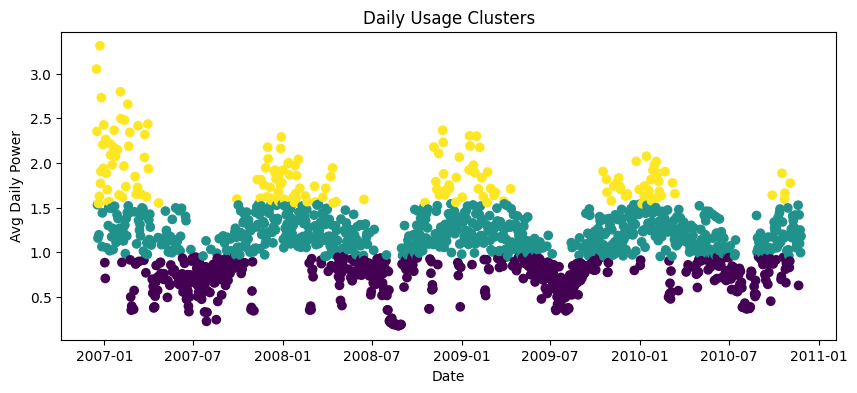

In [14]:
plt.figure(figsize=(10,4))
plt.scatter(daily_profile.index,
            daily_profile['Global_active_power'],
            c=daily_profile['Cluster'])
plt.title("Daily Usage Clusters")
plt.xlabel("Date")
plt.ylabel("Avg Daily Power")
plt.show()


TASK 4 - SIMPLE RULE BASED AI

In [15]:
def categorize_usage(value):
    if value < 2:
        return "Low Usage"
    elif value < 4:
        return "Medium Usage"
    else:
        return "High Usage"


In [16]:
def usage_suggestion(category):
    if category == "Low Usage":
        return "Good job! Continue normal usage."
    elif category == "Medium Usage":
        return "Consider turning off unused appliances."
    elif category == "High Usage":
        return "Warning! Reduce heavy-load appliances to save cost."


In [17]:
example_value = float(pred[-1])   # last predicted value
category = categorize_usage(example_value)
suggestion = usage_suggestion(category)

print("Predicted Power:", example_value)
print("Category:", category)
print("Suggestion:", suggestion)


Predicted Power: 0.916404684816473
Category: Low Usage
Suggestion: Good job! Continue normal usage.
